# Importation of libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preprocessing

Data import

In [3]:
# Read of the local csv file with pandas
data=pd.read_csv("data/fer20131.csv")
# display of the firsts rows of the data
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


Data vizualisation

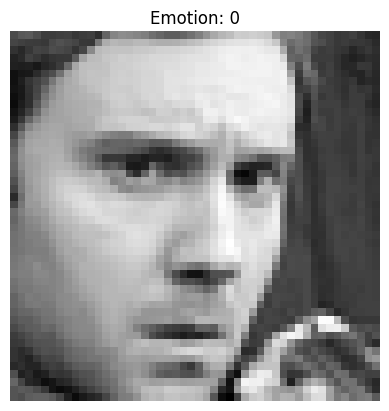

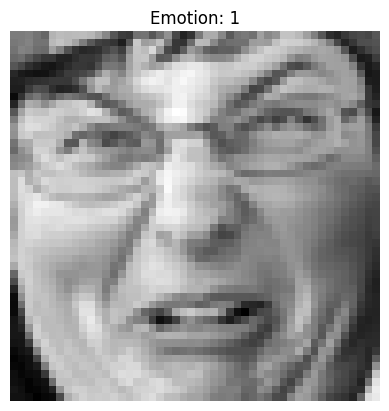

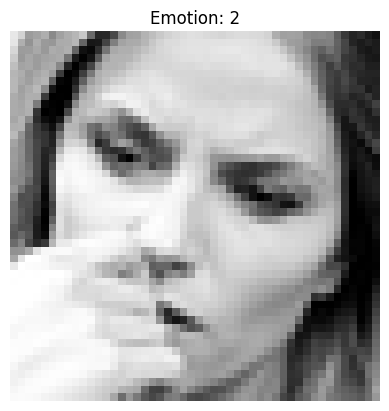

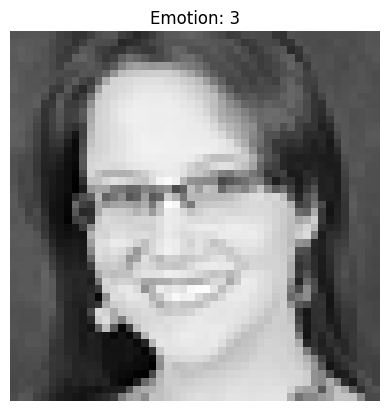

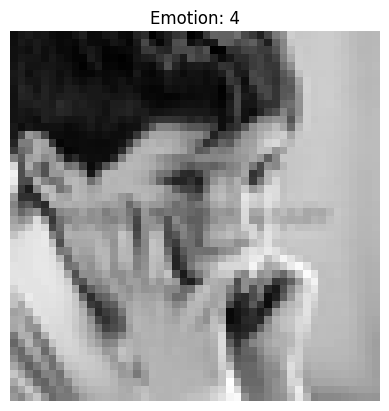

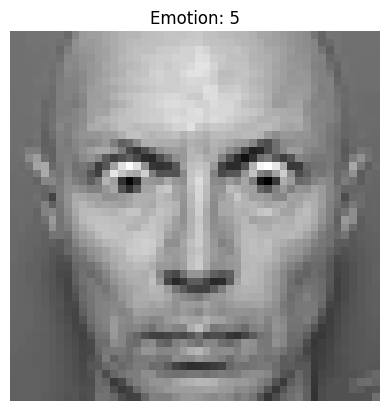

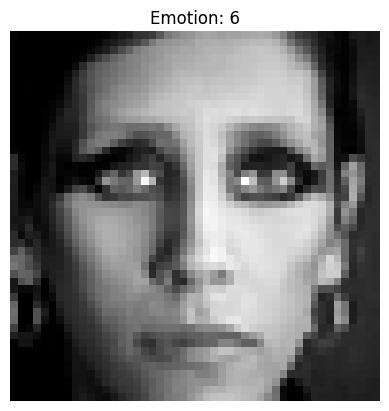

In [4]:
# Show an examples of images for each emotions
dimension = (np.sqrt(len(data['pixels'][0].split())))
examples = data.groupby('emotion').first()['pixels']

i = 0
for pixels in examples:
    # Convert numpy array into images
    image = np.array(list(map(int, pixels.split()))).reshape(48, 48)
    # Swow the image
    plt.imshow(image, cmap='gray')
    plt.title('Emotion: ' + str(examples.index[i]))
    i += 1
    plt.axis('off')
    plt.show()

Data analyze

In [5]:
# Display the different classes of emotions
emotions = data['emotion'].unique()
print(emotions)

# Show the differents type of subdataset and their length
usages = data['Usage'].unique()
print(usages)
training_data = data[data['Usage'] == 'Training']
private_test_data = data[data['Usage'] == 'PrivateTest']
public_test_data = data[data['Usage'] == 'PublicTest']
print('number of training images = ',len(training_data))
print('number of private test images = ',len(private_test_data))
print('number of public test images = ',len(public_test_data))

[0 2 4 6 3 5 1]
['Training' 'PublicTest' 'PrivateTest']
number of training images =  28709
number of private test images =  3589
number of public test images =  3589


<BarContainer object of 7 artists>

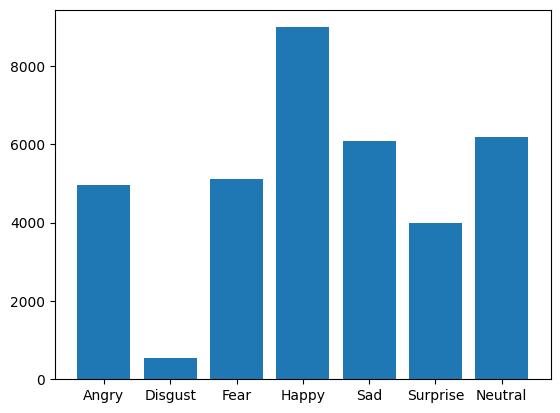

In [6]:
# Analysis of emotion's distribution
emo = ['Angry', 'Disgust' , 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
data_emotion = data['emotion']
distribution = data_emotion.value_counts().sort_index()
plt.bar(emo,distribution.values)

We see that Disgust class is not enough represented, to avoid bad approximation of the model, let's delete this emotion from training and more globaly from the project

Data manipulation

In [7]:
# Spliting the dataset into subdataset and normalization of the value of the pixel (between 0 and 1)
def Split_data(data,usage):
  selected_data = data.loc[(data['emotion'] != 1)&(data['Usage']== usage)] #We put the condition data['emotion'] != 1 to exclude 'disgust'
  X = np.zeros((len(selected_data), 48, 48,1))
  for l in range(len(selected_data)):
    X[l] = np.array(selected_data['pixels'].iloc[l].split(), dtype=int).reshape((48, 48,1))
  X=X/255.
  Y = to_categorical(selected_data['emotion'])
  return X,Y

X_train, Y_train= Split_data(data,'Training')
X_val, Y_val= Split_data(data,'PrivateTest')
X_test, Y_test= Split_data(data,'PublicTest')

# Display the dimension of the splitted dataset
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(28273, 48, 48, 1)
(28273, 7)
(3533, 48, 48, 1)
(3533, 7)
(3534, 48, 48, 1)
(3534, 7)


Although one emotion, disgust, was removed, the reason why Y has 7 columns is that `to_categorical()` retained the numbering of the emotions as it was, thus keeping its second column (index = 1) null

# Model building, training and saving

Building

The model consists of:
- 3 blocks, each containing:
  - 3 convolutional layers, with 32, 64, and 128 filters of size (3, 3), using `padding='same'` and `activation='relu'`
  - A max pooling layer with `pool_size=(2, 2)`
  - A Flatten layer
- 2 fully connected (dense) layers with 64 neurons and `activation='relu'`
- A final classification layer


In [8]:
# Fonction for the final block
def create_conv_block():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    return model

# Initialization of the model
expression_model = Sequential()

# First block of layers
expression_model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
expression_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
expression_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

# Second and third (identical) block of layer 
expression_model.add(create_conv_block())
expression_model.add(create_conv_block())
expression_model.add(Flatten())

#Two fully connected layers with 'relu' activation
expression_model.add(Dense(64, activation='relu'))
expression_model.add(Dense(64, activation='relu'))
expression_model.add(Dense(7, activation='sigmoid')) # Final classification layer

c:\Users\gaudr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training

- The `expression_model.fit()` method is configured for model training.
- Training uses `X_train` and `Y_train` with 20 epochs and a batch size of 128.
- `steps_per_epoch` is set to 100 for iteration control per epoch.
- Validation uses `X_val` and `Y_val`, with `validation_steps` set to 50.

WARNING : This script takes a lot of time according to your local machine

In [ ]:
# Training with the specified hyperparameters
history = expression_model.fit(
    X_train,
    Y_train,
    steps_per_epoch=100,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, Y_val),
    validation_steps=50
)

NameError: name 'expression_model' is not defined

Saving

In [ ]:
# Save of the model to use it without running the code 
expression_model.save('facial_recognition.h5')

# Model benchmarking

Visualization of the training process (with loss and accuracy)

In [ ]:
# Collecting the history of training
history_dict = history.history

# Extracting the value for loss and precision for both training and validation
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Setting the number of epochs on the graph
epochs = range(1, len(loss) + 1)

# Plotting of loss 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Perte - Entraînement')
plt.plot(epochs, val_loss, 'r-', label='Perte - Validation')
plt.title("Évolution de la perte (fonction coût)")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Plotting of accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Précision - Entraînement')
plt.plot(epochs, val_accuracy, 'r-', label='Précision - Validation')
plt.title("Évolution de la précision (accuracy)")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()

plt.tight_layout()
plt.show()


Evaluation on the test part

In [10]:
#Load of the model
expression_model = load_model('models/facial_recognition_model.h5')

In [11]:
# Evaluation
loss, accuracy = expression_model.evaluate(X_test, Y_test)

print("Cost (loss function) on test data :", loss)
print("Acurracy on test data :", accuracy)

111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5515 - loss: 1.1909
Cost (loss function) on test data : 1.2003942728042603
Acurracy on test data : 0.542881429195404


Recognition rate for each class

In [12]:
# Obtain predictions on tests
y_pred = expression_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convertir les prédictions en classes

# Convertir the results as the emotion_index
y_true = Y_test.argmax(axis=1)

# Generate the report
classes = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
report = classification_report(y_true, y_pred_classes, target_names=classes)
print(report)

111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step
              precision    recall  f1-score   support

       Angry       0.49      0.38      0.43       467
        Fear       0.46      0.21      0.29       496
       Happy       0.75      0.76      0.76       895
         Sad       0.40      0.50      0.45       653
    Surprise       0.78      0.63      0.70       415
     Neutral       0.41      0.60      0.49       607

    accuracy                           0.54      3533
   macro avg       0.55      0.51      0.52      3533
weighted avg       0.56      0.54      0.54      3533



In [13]:
# Visualization of the confusion matrix
print(confusion_matrix(y_true, y_pred_classes))

[[178  22  38 104  12 113]
 [ 61 103  32 142  34 124]
 [ 28  14 684  78  13  78]
 [ 49  34  61 325  10 174]
 [ 20  31  33  28 263  40]
 [ 27  19  64 127   5 365]]


# Data augmentation : Modify data to strenghten the model

What we want to do is to strenghten the model by making the training harder :
For that we will make the data less recognizable : This process is called data augmentation
We will apply little transformation to our train images : rotation, zoom, flip...

In [ ]:
# Data augmentation process
# Creation of a data augmented generator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply the generator on the train dataset
datagen.fit(X_train)

# Train the model on the enchanced dataset
history2 = expression_model.fit(
    datagen.flow(X_train, Y_train, batch_size=128),
    steps_per_epoch=100,
    epochs=20,
    # validation_data=(X_val, Y_val),
    validation_steps=50
)

Save the new model

In [ ]:
# Save the model
expression_model.save('augmented_facial_recognition.h5')

# Augmented Model Benchmarking

In [15]:
# Load the model
augmented_expression_model = load_model('models/augmented_facial_recognition_model.h5')

In [16]:
# Evaluation of the new model
loss, accuracy = augmented_expression_model.evaluate(X_test, Y_test)

print("Loss (cost function) on test data : ", loss)
print("Accuracy on test data : ", accuracy)

111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5511 - loss: 1.1629
Loss (cost function) on test data :  1.1671991348266602
Accuracy on test data :  0.5451457500457764


The accuracy increase by __% with this data augmentation